# Proyek Klasifikasi Gambar: EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install split-folders

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflowjs as tfjs
import tensorflowjs.converters as tfllite

from sklearn.metrics import classification_report

import splitfolders
import zipfile, os
import shutil

In [ ]:
 !pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.8.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.7.7.0.39.39
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.10.1
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.7.9
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy

## Data Loading and Preparation

In [ ]:
# Original from https://zenodo.org/records/7711810#.ZAm3k-zMKEA

!curl -L -o eurosat-dataset.zip https://www.kaggle.com/api/v1/datasets/download/apollo2506/eurosat-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2092M  100 2092M    0     0   139M      0  0:00:14  0:00:14 --:--:--  213M


In [ ]:
zip_file = '/content/eurosat-dataset.zip'
extracted = '/content/eurosat'

zip_ref= zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall(extracted)

In [ ]:
# Delete unneccessary folder and file

delete_allBands = '/content/eurosat/EuroSATallBands'

delete_label = '/content/eurosat/EuroSAT/label_map.json'
delete_testCSV = '/content/eurosat/EuroSAT/test.csv'
delete_trainCSV = '/content/eurosat/EuroSAT/train.csv'
delete_validationCSV = '/content/eurosat/EuroSAT/validation.csv'

shutil.rmtree(delete_allBands)
os.remove(delete_label)
os.remove(delete_testCSV)
os.remove(delete_trainCSV)
os.remove(delete_validationCSV)

In [ ]:
input = '/content/eurosat/EuroSAT'
output = '/content/split'

splitfolders.ratio(input, output, seed=42, ratio=(.8, .1, .1))

Copying files: 27000 files [00:03, 8181.38 files/s]


In [ ]:
test_dir = '/content/split/test'
train_dir = '/content/split/train'
val_dir = '/content/split/val'

print(os.listdir(train_dir))

['River', 'Pasture', 'Forest', 'Residential', 'Industrial', 'AnnualCrop', 'PermanentCrop', 'HerbaceousVegetation', 'Highway', 'SeaLake']


In [ ]:
def count_images(directory):
    total_images = 0
    for category in os.listdir(directory):  # Loop through each class folder
        class_path = os.path.join(directory, category)
        if os.path.isdir(class_path):  # Ensure it's a directory
            total_images += len(os.listdir(class_path))  # Count images in class
    return total_images


train_count = count_images(train_dir)
val_count = count_images(val_dir)
test_count = count_images(test_dir)

# Print results
print(f"Total images in Train set: {train_count}")
print(f"Total images in Validation set: {val_count}")
print(f"Total images in Test set: {test_count}")

Total images in Train set: 21600
Total images in Validation set: 2700
Total images in Test set: 2700


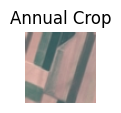

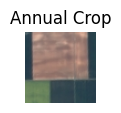

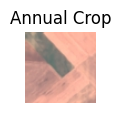

In [ ]:
for i in range(3):
  plt.subplot(3, 6, i+1)
  img = tf.keras.utils.load_img(train_dir + '/AnnualCrop/' + os.listdir(train_dir + '/AnnualCrop')[i])
  plt.imshow(img)
  plt.axis("off")

  plt.title("Annual Crop")
  plt.show()

### Data Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
     rescale=1.0/255,
     rotation_range=15,
     height_shift_range=0.1,
     shear_range=0.1,
     zoom_range=0.1,
     brightness_range=(0.8, 1.2),
     fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
     test_dir,
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical',
     shuffle=False,
 )


Found 21600 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.


In [ ]:
for cls in os.listdir(train_dir):
    count = len(os.listdir(os.path.join(train_dir, cls)))
    print(f"{cls}: {count} images")


River: 2000 images
Pasture: 1600 images
Forest: 2400 images
Residential: 2400 images
Industrial: 2000 images
AnnualCrop: 2400 images
PermanentCrop: 2000 images
HerbaceousVegetation: 2400 images
Highway: 2000 images
SeaLake: 2400 images


Label vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


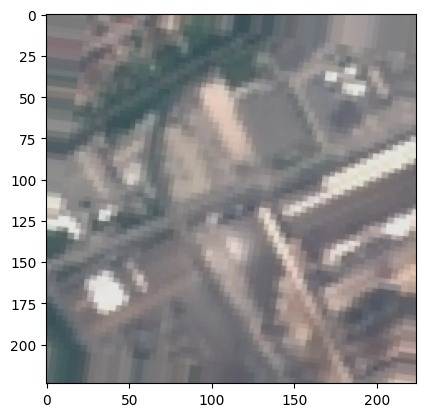

In [ ]:
x, y = next(train_generator)
plt.imshow(x[0])
print("Label vector:", y[0])

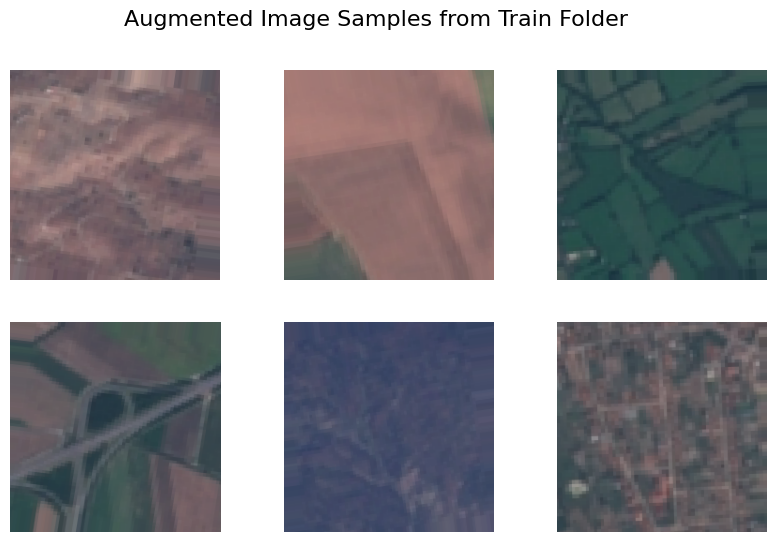

In [ ]:
augmented_images, _ = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis("off")

plt.suptitle("Augmented Image Samples from Train Folder", fontsize=16)
plt.show()

## Modelling

In [ ]:
def build_model():

    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,014,538 (11.50 MB)

 Trainable params: 756,554 (2.89 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data= val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
        ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 307s 434ms/step - accuracy: 0.5280 - loss: 1.3964 - val_accuracy: 0.8363 - val_loss: 0.5015 - learning_rate: 1.0000e-04
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 300s 413ms/step - accuracy: 0.8105 - loss: 0.6020 - val_accuracy: 0.8600 - val_loss: 0.4383 - learning_rate: 1.0000e-04
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 280s 415ms/step - accuracy: 0.8446 - loss: 0.4854 - val_accuracy: 0.8715 - val_loss: 0.3978 - learning_rate: 1.0000e-04
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 286s 424ms/step - accuracy: 0.8661 - loss: 0.4334 - val_accuracy: 0.8752 - val_loss: 0.3782 - learning_rate: 1.0000e-04
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 292s 433ms/step - accuracy: 0.8717 - loss: 0.4027 - val_accuracy: 0.8730 - val_loss: 0.3676 - learning_rate: 1.0000e-04
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 289s 428ms/step - accuracy: 0.8787 - loss: 0.3909 - val_accuracy: 0.8822 - val_loss: 0.3597 - learning_rate: 1.0000e-04
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Fine tuning

model.layers[0].trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 344s 438ms/step - accuracy: 0.6354 - loss: 1.1702 - val_accuracy: 0.3741 - val_loss: 5.5309 - learning_rate: 1.0000e-05
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 296s 433ms/step - accuracy: 0.8418 - loss: 0.5167 - val_accuracy: 0.4656 - val_loss: 4.2713 - learning_rate: 1.0000e-05
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 296s 438ms/step - accuracy: 0.8725 - loss: 0.4201 - val_accuracy: 0.6174 - val_loss: 1.7961 - learning_rate: 1.0000e-05
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 301s 446ms/step - accuracy: 0.8966 - loss: 0.3416 - val_accuracy: 0.7344 - val_loss: 1.0084 - learning_rate: 1.0000e-05
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 293s 434ms/step - accuracy: 0.9065 - loss: 0.3007 - val_accuracy: 0.8289 - val_loss: 0.5443 - learning_rate: 1.0000e-05
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 292s 433ms/step - accuracy: 0.9174 - loss: 0.2858 - val_accuracy: 0.8552 - val_loss: 0.4490 - learning_rate: 1.0000e-05
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluasi dan Visualisasi

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9198 - loss: 0.2422
Test loss: 0.2338
Test accuracy: 0.9248


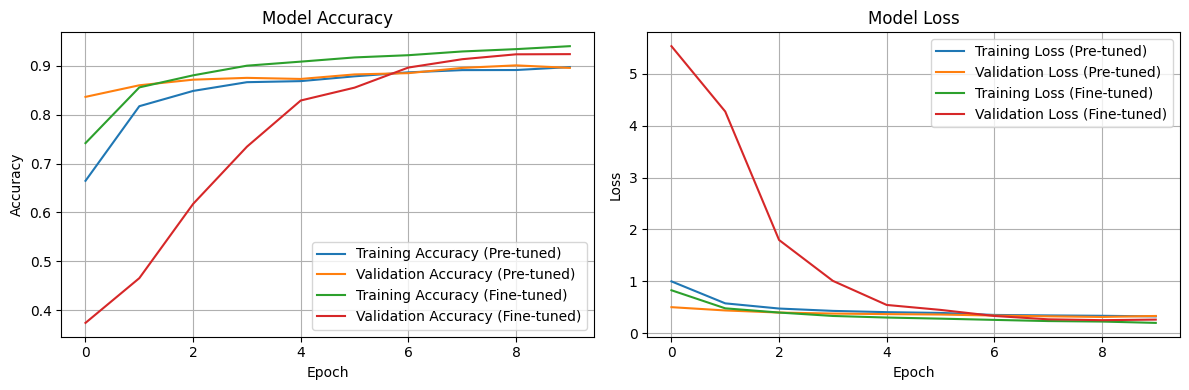

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy (Pre-tuned)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Pre-tuned)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Fine-tuned)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuned)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss (Pre-tuned)')
plt.plot(history.history['val_loss'], label='Validation Loss (Pre-tuned)')
plt.plot(history_finetune.history['loss'], label='Training Loss (Fine-tuned)')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss (Fine-tuned)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Classification Report

test_generator.reset()

predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.96      0.92      0.94       300
              Forest       1.00      0.89      0.94       300
HerbaceousVegetation       0.80      0.95      0.87       300
             Highway       0.97      0.95      0.96       250
          Industrial       1.00      0.82      0.90       250
             Pasture       0.99      0.80      0.88       200
       PermanentCrop       0.84      0.92      0.88       250
         Residential       0.95      0.99      0.97       300
               River       0.90      0.96      0.93       250
             SeaLake       0.93      1.00      0.96       300

            accuracy                           0.92      2700
           macro avg       0.93      0.92      0.92      2700
        weighted avg       0.93      0.92      0.92      2700



## Konversi Model

In [ ]:
# SavedModel

save_path = '/content/saved_model/1/'
tf.saved_model.save(model, save_path)

In [ ]:
# Tensorflow JS
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  /content/saved_model/1/ \
  /content/tfjs_model/

2025-07-13 06:46:54.326163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752389214.451284   31928 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752389214.509751   31928 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-07-13 06:47:01.198047: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1752389221.198226   31928 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
# TFLite

converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
class_labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

with open('labels.txt', 'w') as f:
    for label in class_labels:
        f.write(label + '\n')

In [ ]:
shutil.make_archive('/content/tfjs_model', 'zip', '/content/tfjs_model')
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

with zipfile.ZipFile('/content/model.tflite.zip', 'w') as zipf:
    zipf.write('model.tflite')

## Inference (Optional)